<a href="https://colab.research.google.com/github/RODRIGORUBIO1991/PythonCode/blob/main/IT%20SALARIOS/IT_Salarios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align='center'> Emisiones en Rwanda 💥 <h1>


# Introducción

En la actualidad, la necesidad de comprender y abordar el cambio climático ha impulsado el desarrollo de tecnologías avanzadas para monitorear y predecir las emisiones de carbono, un factor crucial en la huella ambiental. En este contexto, el presente estudio se enfoca en la creación de modelos de aprendizaje automático que hacen uso de datos de emisiones de código abierto, provenientes de las observaciones del satélite Sentinel-5P. El objetivo primordial de esta investigación es predecir las emisiones de dióxido de carbono (CO2) en un marco temporal específico.

El conjunto de datos proporcionado se origina en múltiples regiones de Ruanda, abarcando una variada selección de áreas que incluyen tierras agrícolas, zonas urbanas y centrales eléctricas. Estos datos, recolectados semanalmente desde enero de 2019 hasta noviembre de 2022, comprenden características fundamentales como dióxido de azufre, monóxido de carbono, dióxido de nitrógeno, formaldehído, índice de aerosol UV, ozono y nubosidad. Cada una de estas características contiene subcaracterísticas que aportan detalles valiosos sobre la densidad vertical y otros aspectos importantes de las mediciones.

En este contexto, el desafío planteado radica en la capacidad de construir modelos precisos que aprovechen estos datos para predecir las emisiones de CO2 con una perspectiva temporal específica. El conjunto de datos de entrenamiento abarca desde 2019 hasta 2021, y la tarea consiste en pronosticar las emisiones de CO2 para el período que comprende el año 2022 hasta noviembre. Un aspecto crucial es que únicamente se permite el uso de los datos proporcionados en el contexto de este desafío, excluyendo cualquier información externa, incluidos los datos del satélite Sentinel-5P que no se ofrecen en la página.

En resumen, este estudio se adentra en el campo interdisciplinario de la ciencia de datos y la sostenibilidad ambiental, donde el análisis avanzado de datos de emisiones y la aplicación de modelos de aprendizaje automático permiten una predicción informada de las emisiones de CO2. El siguiente trabajo presenta la metodología y los resultados de los modelos desarrollados, en un esfuerzo por contribuir a la comprensión y mitigación de los efectos del cambio climático.

# Librerias y Carga de Datos 📁

In [1]:
import warnings
warnings.filterwarnings("ignore")

import gc
import numpy as np 
import pandas as pd
import datetime as dt

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

import folium
import geopandas as gpd
from haversine import haversine

import optuna
import xgboost as xgb


import folium
import geopandas as gpd

from sklearn.ensemble import RandomForestRegressor

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter


pd.set_option('display.max_columns', None)

# Leer el conjunto de entrenamiento
train = pd.read_csv('train.csv')

# Leer el conjunto de prueba
test = pd.read_csv('test.csv')

# Leer el archivo de muestra de presentación
sample = pd.read_csv('sample_submission.csv')

bold = ['\033[1m', '\033[0m']
seed = 228

# Data analysis 📊


In [2]:
summary = train.shape
print("Número de filas:", summary[0])
print("Número de columnas:", summary[1])


Número de filas: 79023
Número de columnas: 76


In [3]:
# Calcular porcentajes de valores nulos y conteo de valores no nulos
def calculate_null_percent(df):
    null_percent = round(df.isnull().mean() * 100, 2)
    non_null_count = df.notnull().sum()
    return pd.DataFrame({'Null (%)': null_percent, 'Non-Null Count': non_null_count})

train_null_info = calculate_null_percent(train)
test_null_info = calculate_null_percent(test)

# Combinar los porcentajes y el conteo en un DataFrame
df_mv = pd.concat([train_null_info, test_null_info], axis=1)
df_mv.columns = pd.MultiIndex.from_tuples([('Entrenamiento', 'Null (%)'), ('Entrenamiento', 'Non-Null Count'),
                                          ('Prueba', 'Null (%)'), ('Prueba', 'Non-Null Count')])
df_mv.reset_index(inplace=True)
df_mv.rename(columns={'index': 'Column'}, inplace=True)

# Establecer estilos y mostrar
df_mv_styled = df_mv.style.highlight_null(null_color='red').background_gradient(cmap=sns.light_palette("green", as_cmap=True))
df_mv_styled.set_properties(**{'text-align': 'center'}, subset='Column')
df_mv_styled.set_properties(**{'text-align': 'center'}, subset=[('Entrenamiento', 'Null (%)'), ('Prueba', 'Null (%)')])
df_mv_styled.set_properties(**{'text-align': 'center'}, subset=[('Entrenamiento', 'Non-Null Count'), ('Prueba', 'Non-Null Count')])
df_mv_styled.set_properties(**{'font-weight': 'bold'}, subset=[('Entrenamiento', 'Non-Null Count'), ('Prueba', 'Non-Null Count')])
df_mv_styled.set_precision(2)

display(df_mv_styled)


Este código analiza los conjuntos de datos de entrenamiento y prueba en busca de valores nulos. Calcula y presenta los porcentajes de valores nulos en cada columna en forma de tabla. Utiliza colores para resaltar las áreas con valores nulos y un gradiente de color para mostrar la intensidad de los porcentajes. Esto permite una visualización clara de las áreas con falta de datos en los conjuntos de datos, lo que facilita la identificación de patrones y áreas a considerar para el análisis adicional.






In [4]:
# Lista de variables a eliminar
columns_to_drop = [
    'UvAerosolLayerHeight_aerosol_height',
    'UvAerosolLayerHeight_aerosol_pressure',
    'UvAerosolLayerHeight_aerosol_optical_depth',
    'UvAerosolLayerHeight_sensor_zenith_angle',
    'UvAerosolLayerHeight_sensor_azimuth_angle',
    'UvAerosolLayerHeight_solar_azimuth_angle',
    'UvAerosolLayerHeight_solar_zenith_angle'
]

# Eliminar las variables de ambos conjuntos de datos
train = train.drop(columns=columns_to_drop)
test = test.drop(columns=columns_to_drop)



El código proporcionado tiene como objetivo eliminar las variables en los conjuntos de datos "train" y "test" que presentan más del 90% de valores nulos. Estos valores faltantes pueden indicar que dichas variables no contienen información significativa para el análisis. 

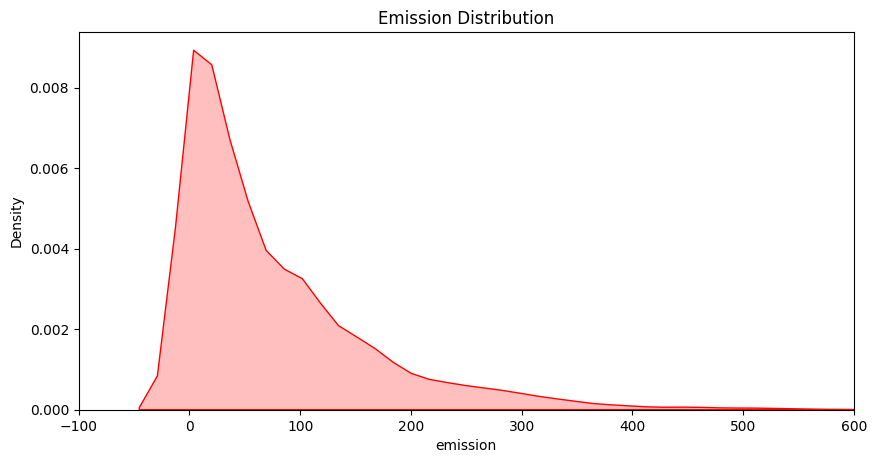

In [7]:
plt.figure(figsize=(10, 5), dpi=100)

sns.kdeplot(data=train, x='emission', fill=True, color='red')

plt.title('Emission Distribution', fontsize=12, fontweight='normal', color='black')
plt.xlim(-100, 600)  # Establecer el límite del eje X
plt.show()


El pico en la distribución del KDE en torno a 0.009 indica que hay una concentración relativamente alta de valores de emisión alrededor de ese valor. 

Por otro lado, los valores de emisión tienden a concentrarse en el rango entre 0 y 300, con un pico más prominente en el rango de 20 a 50. Esto podría sugerir que la mayoría de las emisiones en tus datos se encuentran en ese rango.

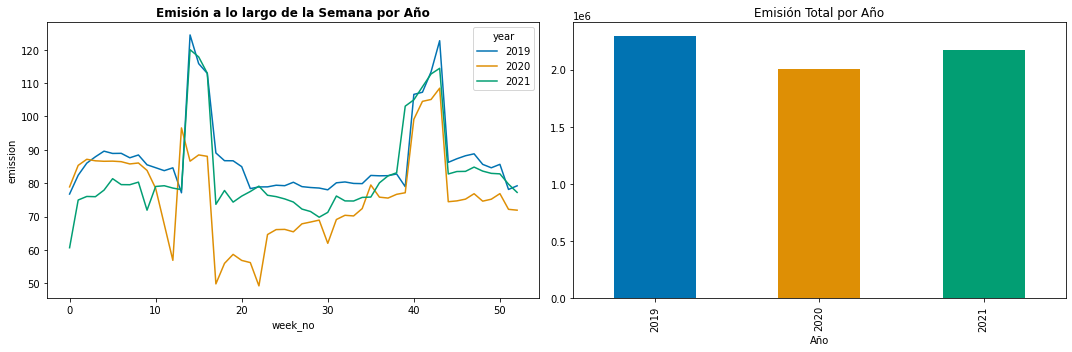

In [8]:
# Crear subgráficos con 1 fila y 2 columnas
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Primer gráfico: Gráfico de líneas de emisión por semana y año
sns.lineplot(data=train, x='week_no', y='emission', hue='year', errorbar=None, palette='colorblind', ax=axs[0])
axs[0].set_title('Emisión a lo largo de la Semana por Año', fontsize=12, fontweight='bold')

# Segundo gráfico: Gráfico de barras de la suma de emisión por año
train_agrupado_por_año = train.groupby('year')['emission'].sum()
train_agrupado_por_año.plot(kind='bar', title='Emisión Total por Año', xlabel='Año', color=sns.color_palette('colorblind'), ax=axs[1])

# Ajustar el diseño de los subgráficos
plt.tight_layout()
plt.show()



En el primer subgráfico, se muestra un gráfico de líneas que representa la variación de las emisiones a lo largo de las semanas para diferentes años, con cada año distinguido por un color. 

En el segundo subgráfico, se presenta un gráfico de barras que muestra la suma total de emisiones para cada año. 

In [26]:

# Crear una nueva columna 'year_week'
year_week = pd.to_datetime((train.year * 100 + train.week_no).astype('str') + '0', format='%Y%W%w')
train['year_week'] = year_week

# Calcular el Q1 y Q3 para la emisión usando el método quantile
Q1 = train['emission'].quantile(0.25)
Q3 = train['emission'].quantile(0.75)

# Calcular el IQR (rango intercuartílico)
IQR = Q3 - Q1

# Definir los límites para considerar los valores atípicos
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar los datos para eliminar los outliers
filtered_train = train[(train['emission'] >= lower_bound) & (train['emission'] <= upper_bound)]


Este código primero crea una columna de fechas "year_week" basada en los valores de año y semana del conjunto de datos "train". Luego calcula los cuartiles y el rango intercuartílico de la columna de emisiones. Con estos valores, define límites para identificar valores atípicos. Finalmente, filtra el conjunto de datos original "train" para retener solo las filas cuyas emisiones estén dentro de los límites establecidos, creando así un nuevo conjunto de datos "filtered_train" sin valores atípicos.






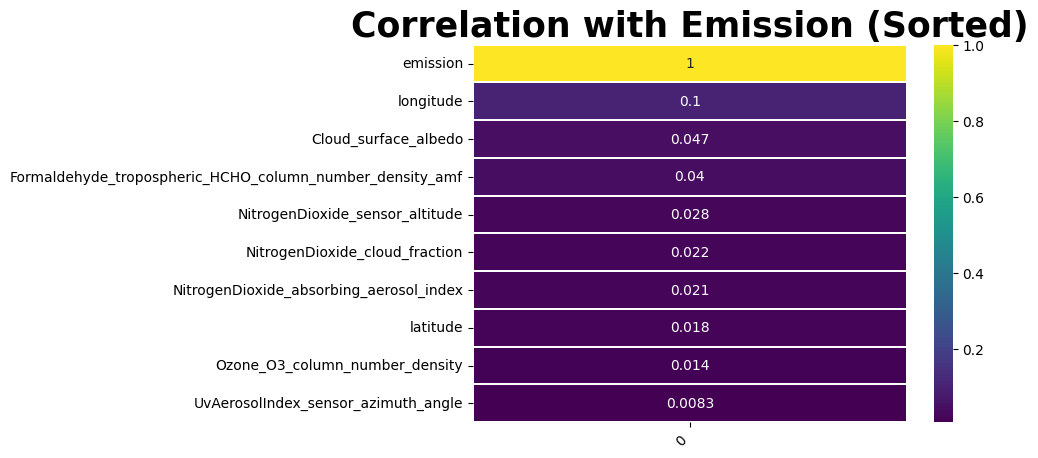

In [38]:
def heatmap_with_emission_correlation(dataset):
    columns = list(dataset)
    corr_with_emission = dataset.corrwith(dataset['emission']).sort_values(ascending=False)[:10]  # Calcula y ordena la correlación con la variable "emission"
    plt.figure(figsize=(7, 5), dpi=100)
    sns.heatmap(corr_with_emission.to_frame(), annot=True, cmap='viridis', linewidths=.1)
    plt.title('Correlation with Emission (Sorted)', fontsize=25, weight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Llamar a la función pasando tu conjunto de datos
heatmap_with_emission_correlation(train)



Se calculan las 10 varibles con mayor correlacion con respecto a "emission". 

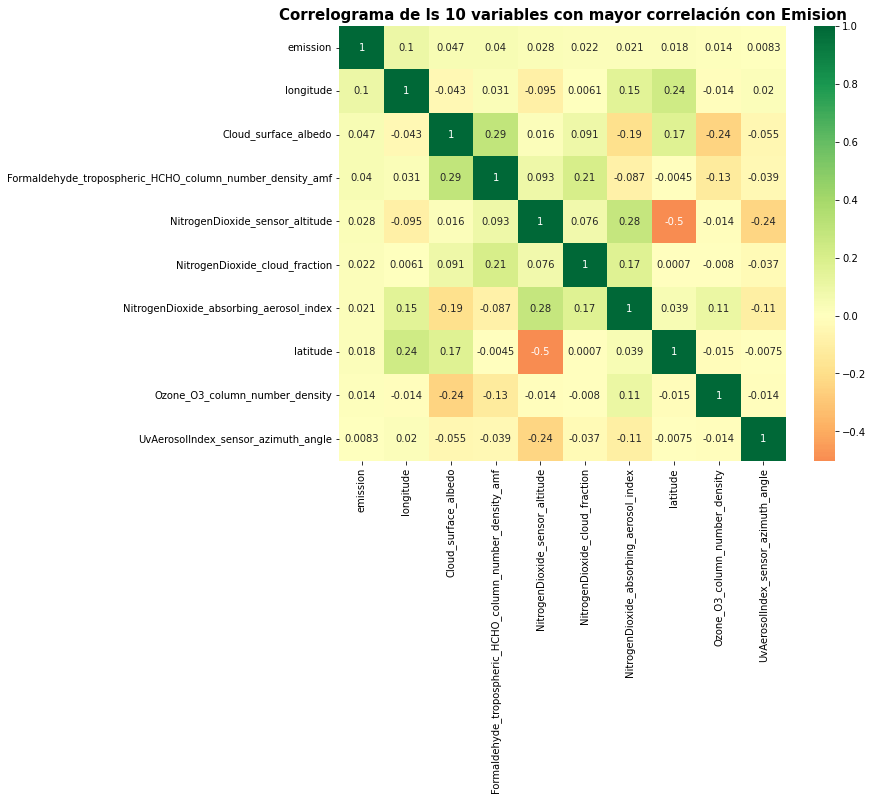

In [40]:

# Obtener las 10 variables con mayor correlación con 'emission'
corr_with_emission = train.corrwith(train['emission']).sort_values(ascending=False)[:10]

# Crear un DataFrame con estas 10 variables
top10_correlation_df = train[corr_with_emission.index]

# Calcular la matriz de correlaciones para las 10 variables
corr_matrix_top10 = top10_correlation_df.corr()

# Crear un correlograma para las 10 variables
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_top10, cmap='RdYlGn', annot=True, center=0)
plt.title('Correlograma de ls 10 variables con mayor correlación con Emision', fontsize=15, weight='bold')
plt.show()


Se observan que no hay una ninguna correlación mayor al 70%, por lo tanto no se eliminarán variables.

# Modelado 🪄

In [21]:
# Crear un GeoDataFrame con coordenadas únicas de los datos de entrenamiento
coordenadas_entrenamiento = train.drop_duplicates(subset=['latitude', 'longitude'])
geometria = gpd.points_from_xy(coordenadas_entrenamiento.longitude, coordenadas_entrenamiento.latitude)
geo_df = gpd.GeoDataFrame(coordenadas_entrenamiento[['latitude', 'longitude']], geometry=geometria)

# Crear un mapa base
mapa_todos_los_datos = folium.Map(location=[geo_df['latitude'].mean(), geo_df['longitude'].mean()],
                                  zoom_start=10, control_scale=True, prefer_canvas=True)

# Crear una lista de coordenadas a partir del GeoDataFrame
lista_geo_df = [[punto.xy[1][0], punto.xy[0][0]] for punto in geo_df.geometry]

# Iterar a través de la lista y agregar un marcador para cada ubicación
for coordenadas in lista_geo_df:
    folium.CircleMarker(
        location=coordenadas,
        radius=1,
        weight=4,
        color='blue',  # Cambiado el color a azul
        fill=True,
        fill_opacity=0.5
    ).add_to(mapa_todos_los_datos)

# Ajustar el mapa a los límites de los marcadores
mapa_todos_los_datos.fit_bounds(mapa_todos_los_datos.get_bounds())

# Mostrar el mapa
mapa_todos_los_datos



Se contempla que los puntos de análisis no se encuentran únicamente en Rwanda, es por ello que se aplica un nuevo código para lograr identificar correctamente a que países corresponden los datos.

In [12]:
def buscador_de_ubicacion(entrenamiento):
    # Colocar todas las coordenadas únicas en un DataFrame
    ubicacion = (entrenamiento.latitude.astype('str') + ', ' + entrenamiento.longitude.astype('str')).drop_duplicates().reset_index()

    # Definir geolocalizador como API de Nominatim
    geolocalizador = Nominatim(user_agent='Iqbal Syah Akbar', timeout=10)

    # Definir limitador de velocidad para evitar demasiadas solicitudes
    rgeocode = RateLimiter(geolocalizador.reverse, min_delay_seconds=1)
    return ubicacion[0].apply(rgeocode)

# Llamar a la función con el DataFrame de entrenamiento como argumento
resultado_extraccion = buscador_de_ubicacion(entrenamiento)


Este fragmento de código define una función que toma un conjunto de datos de entrenamiento y busca la ubicación correspondiente a las coordenadas de latitud y longitud. 

La función crea un DataFrame con ubicaciones únicas y luego aplica el proceso de geolocalización. 

Esto nos permite convertir las coordenadas en nombres de ubicaciones significativos, lo que puede ser útil para un análisis geográfico más comprensible.






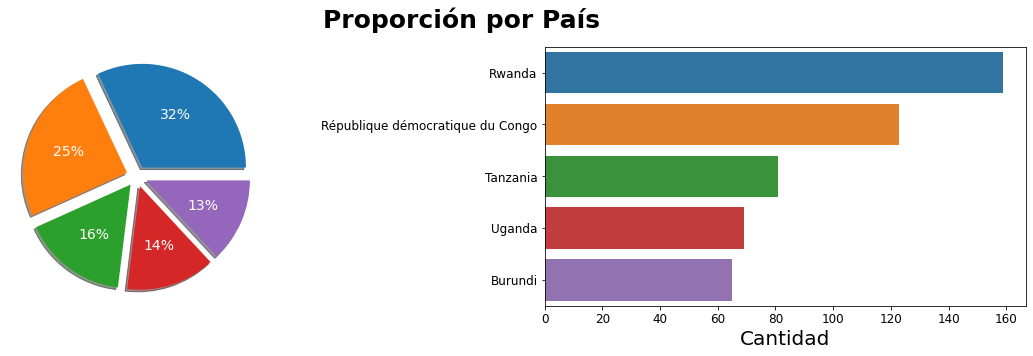

In [24]:

# Código para obtener la ubicación
get_country = lambda x: x.raw['address']['country']
get_state = lambda x: x.raw['address']['state']
get_full_address = lambda x: x.raw['display_name']

location = train[['latitude', 'longitude']].drop_duplicates().reset_index().drop('index', axis=1)
location['country'] = extraction_result.apply(get_country)
location['state'] = extraction_result.apply(get_state)
location['full_address'] = extraction_result.apply(get_full_address)

# Código para la visualización de los gráficos
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax = ax.flatten()

ax[0].pie(
    location['country'].value_counts(),
    shadow=True,
    explode=[.1 for i in range(0, 5)],
    autopct='%1.f%%',
    textprops={'size': 14, 'color': 'white'}
)

sns.countplot(data=location, y='country', ax=ax[1], order=location['country'].value_counts().index)
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize=12)
ax[1].set_xlabel('Cantidad', fontsize=20)
ax[1].set_ylabel(None)
plt.xticks(fontsize=12)

fig.suptitle('Proporción por País', fontsize=25, fontweight='bold')
plt.tight_layout()
plt.show()


Se contempla que Rwanda es el país con mayor porcentaje pero solo posee un 32% de los puntos medidos.

La Rep. Democrática de Congo posee un elevado valor de 25%, seguido por Tanzania, Uganda y Burundi.